# 0. Dependências

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.datasets import make_blobs, make_circles, make_moons, make_classification
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from utils import plots
from utils.samples_generator import make_spiral, make_square, make_cubic, make_exp, make_log10

# 1. Introdução

# 2. Dados 

Os dados de cada tipo de problema (regressão, classificação binária e multiclasse) estão definidos nos testes da implementação.

# 3. Implementação 

###  Funções de ativação

In [2]:
def linear(x, derivative=False):
    return np.ones_like(x) if derivative else x


def sigmoid(x, derivative=False):
    if derivative:
        y = sigmoid(x)
        return y * (1 - y)
    return 1.0 / (1.0 + np.exp(-x))


def tanh(x, derivative=False):
    if derivative:
        y = tanh(x)
        return 1 - y**2
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))


def relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0, 1)
    return np.maximum(0, x)


def leaky_relu(x, derivative=False):
    alpha = 0.1
    if derivative:
        return np.where(x <= 0, alpha, 1)
    return np.where(x <= 0, alpha * x, x)


def elu(x, derivative=False):
    alpha = 1.0
    if derivative:
        y = elu(x)
        return np.where(x <= 0, y + alpha, 1)
    return np.where(x <= 0, alpha * (np.exp(x) - 1), x)


# other functions
def softmax(x, y_oh=None, derivative=False):
    if derivative:
        y_pred = softmax(x)
        y_correct = np.argmax(y_oh, axis=1)
        pk = y_pred[range(y_pred.shape[0]), y_correct]
        y_pred[range(y_pred.shape[0]), y_correct] = pk * (1.0 - pk)
        return y_pred
    exp = np.exp(x)
    return exp / np.sum(exp, axis=1, keepdims=True)


def neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_correct = np.argmax(y_oh, axis=1)
    pk = y_pred[range(y_pred.shape[0]), y_correct]
    if derivative:
        y_pred[range(y_pred.shape[0]), y_correct] = -1.0 / pk
        return y_pred
    return np.mean(-np.log(pk))

### Funções de Custo 

In [3]:
# cost functions
def mae(y, y_pred, derivative=False):
    if derivative:
        return np.where(y_pred > y, 1, -1) / y.shape[0]
    return np.mean(np.abs(y - y_pred))


def mse(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred) / y.shape[0]
    return 0.5 * np.mean((y - y_pred) ** 2)


def binary_cross_entropy(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])
    return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))


def softmax_neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_softmax = softmax(y_pred)
    y_correct = np.argmax(y_oh, axis=1)
    pk = y_softmax[range(y_softmax.shape[0]), y_correct]
    if derivative:
        return -(y_oh - y_softmax) / y_oh.shape[0]
    return np.mean(-np.log(pk))

### Verificação dos Gradientes

In [4]:
def __compute_approx_grads(nn, x, y, eps=1e-4):
    approx_grads = []
    feed_forward = lambda inp: nn._NeuralNetwork__feedforward(inp)

    for layer in nn.layers:
        w_ori = layer.weights.copy()
        w_ravel = w_ori.ravel()
        w_shape = w_ori.shape

        for i in range(w_ravel.size):
            w_plus = w_ravel.copy()
            w_plus[i] += eps
            layer.weights = w_plus.reshape(w_shape)
            J_plus = nn.cost_func(y, feed_forward(x))

            w_minus = w_ravel.copy()
            w_minus[i] -= eps
            layer.weights = w_minus.reshape(w_shape)
            J_minus = nn.cost_func(y, feed_forward(x))
            approx_grads.append((J_plus - J_minus) / (2.0 * eps))
        layer.weights = w_ori

    return approx_grads


def gradient_checking(nn, x, y, eps=1e-4, verbose=False, verbose_precision=5):
    from copy import deepcopy

    nn_copy = deepcopy(nn)

    nn.fit(x, y, epochs=0)
    grads = np.concatenate([layer._dweights.ravel() for layer in nn.layers])

    approx_grads = __compute_approx_grads(nn_copy, x, y, eps)

    is_close = np.allclose(grads, approx_grads)
    print("{}".format("\033[92mGRADIENTS OK" if is_close else "\033[91mGRADIENTS FAIL"))

    norm_num = np.linalg.norm(grads - approx_grads)
    norm_den = np.linalg.norm(grads) + np.linalg.norm(approx_grads)
    error = norm_num / norm_den
    print("Relative error:", error)

    if verbose:
        np.set_printoptions(precision=verbose_precision, linewidth=200, suppress=True)
        print("Gradientes:", grads)
        print("Aproximado:", np.array(approx_grads))

### Rede Neural

In [5]:
class Layer:
    def __init__(self, input_dim, output_dim, activation=linear):
        self.input = None
        self.weights = np.random.randn(output_dim, input_dim)
        self.biases = np.random.randn(1, output_dim)
        self.activation = activation

        self._activ_inp, self._activ_out = None, None
        self._dweights, self._dbiases = None, None


class NeuralNetwork:
    def __init__(self, cost_func=mse, learning_rate=1e-3):
        self.layers = []
        self.cost_func = cost_func
        self.learning_rate = learning_rate

    def fit(self, x_train, y_train, epochs=100, verbose=10):
        for epoch in range(epochs + 1):
            y_pred = self.__feedforward(x_train)
            self.__backprop(y_train, y_pred)

            if epoch % verbose == 0:
                loss_train = self.cost_func(y_train, self.predict(x_train))
                print("epoch: {0:=4}/{1} loss_train: {2:.8f}".format(epoch, epochs, loss_train))

    def predict(self, x):
        return self.__feedforward(x)

    def __feedforward(self, x):
        self.layers[0].input = x
        for current_layer, next_layer in zip(self.layers, self.layers[1:] + [Layer(0, 0)]):
            y = np.dot(current_layer.input, current_layer.weights.T) + current_layer.biases
            current_layer._activ_inp = y
            current_layer._activ_out = next_layer.input = current_layer.activation(y)
        return self.layers[-1]._activ_out

    def __backprop(self, y, y_pred):
        last_delta = self.cost_func(y, y_pred, derivative=True)
        for layer in reversed(self.layers):
            dactivation = layer.activation(layer._activ_inp, derivative=True) * last_delta
            last_delta = np.dot(dactivation, layer.weights)
            layer._dweights = np.dot(dactivation.T, layer.input)
            layer._dbiases = 1.0 * dactivation.sum(axis=0, keepdims=True)

        for layer in reversed(self.layers):
            layer.weights = layer.weights - self.learning_rate * layer._dweights
            layer.biases = layer.biases - self.learning_rate * layer._dbiases

# 4. Teste 

In [6]:
np.random.seed(1234)
N, D = 100, 2
x = np.random.rand(N, D)
y = np.random.rand(N, 1)

## Verificação dos Gradientes

### Regressão

In [7]:
D_in, D_out = x.shape[1], y.shape[1]
nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=D_in, output_dim=4, activation=relu))
nn.layers.append(Layer(input_dim=4, output_dim=1, activation=tanh))
nn.layers.append(Layer(input_dim=1, output_dim=2, activation=sigmoid))
nn.layers.append(Layer(input_dim=2, output_dim=5, activation=leaky_relu))
nn.layers.append(Layer(input_dim=5, output_dim=3, activation=elu))
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=100)
gradient_checking(nn, x, y, eps=1e-4, verbose=False)

epoch:    0/100 loss_train: 0.09443909
epoch:   10/100 loss_train: 0.08027429
epoch:   20/100 loss_train: 0.06997904
epoch:   30/100 loss_train: 0.06244557
epoch:   40/100 loss_train: 0.05690320
epoch:   50/100 loss_train: 0.05280786
epoch:   60/100 loss_train: 0.04977095
epoch:   70/100 loss_train: 0.04751232
epoch:   80/100 loss_train: 0.04582842
epoch:   90/100 loss_train: 0.04457045
epoch:  100/100 loss_train: 0.04362907
epoch:    0/0 loss_train: 0.04354904
GRADIENTS OK
Relative error: 9.639110524108867e-08


###  Classificação Binária

In [8]:
y = np.random.randint(0, 2, (N, 1))
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=D_in, output_dim=4, activation=relu))
nn.layers.append(Layer(input_dim=4, output_dim=1, activation=tanh))
nn.layers.append(Layer(input_dim=1, output_dim=2, activation=sigmoid))
nn.layers.append(Layer(input_dim=2, output_dim=5, activation=leaky_relu))
nn.layers.append(Layer(input_dim=5, output_dim=3, activation=elu))
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=100)
gradient_checking(nn, x, y, eps=1e-4, verbose=False)

epoch:    0/100 loss_train: 0.89516990
epoch:   10/100 loss_train: 0.88638120
epoch:   20/100 loss_train: 0.87791389
epoch:   30/100 loss_train: 0.86975853
epoch:   40/100 loss_train: 0.86190582
epoch:   50/100 loss_train: 0.85434657
epoch:   60/100 loss_train: 0.84707176
epoch:   70/100 loss_train: 0.84007248
epoch:   80/100 loss_train: 0.83334002
epoch:   90/100 loss_train: 0.82686579
epoch:  100/100 loss_train: 0.82064138
epoch:    0/0 loss_train: 0.82003236
GRADIENTS OK
Relative error: 8.64142521465803e-10


### Classificação Multiclasse

In [9]:
y = np.random.randint(0, 2, (N, 1))
y_oh = OneHotEncoder(sparse_output=False).fit_transform(y)
D_in, D_out = x.shape[1], y_oh.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=D_in, output_dim=4, activation=relu))
nn.layers.append(Layer(input_dim=4, output_dim=1, activation=tanh))
nn.layers.append(Layer(input_dim=1, output_dim=2, activation=sigmoid))
nn.layers.append(Layer(input_dim=2, output_dim=5, activation=leaky_relu))
nn.layers.append(Layer(input_dim=5, output_dim=3, activation=elu))
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=100)
gradient_checking(nn, x, y_oh, eps=1e-4, verbose=False)

epoch:    0/100 loss_train: 0.12266334
epoch:   10/100 loss_train: 0.12896237
epoch:   20/100 loss_train: 0.13561368
epoch:   30/100 loss_train: 0.14264357
epoch:   40/100 loss_train: 0.15003052
epoch:   50/100 loss_train: 0.15641980
epoch:   60/100 loss_train: 0.16203421
epoch:   70/100 loss_train: 0.16764310
epoch:   80/100 loss_train: 0.17338276
epoch:   90/100 loss_train: 0.17926592
epoch:  100/100 loss_train: 0.18529324
epoch:    0/0 loss_train: 1.09074880
GRADIENTS OK
Relative error: 1.4653018042131347e-09


## Regressão

###  Regressão Linear Simples

In [10]:
data = np.loadtxt("data/medidas.csv", delimiter=",", skiprows=1)
print(data.shape)

x, y = data[:, 0].reshape(-1, 1), data[:, 1].reshape(-1, 1)
print(x.shape, y.shape)

(100, 2)
(100, 1) (100, 1)


In [11]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(), x.max())

-1.0 0.9999999999999991


epoch:    0/1000 loss_train: 2252.45947137
epoch:  100/1000 loss_train: 15.74601708
epoch:  200/1000 loss_train: 13.10358581
epoch:  300/1000 loss_train: 13.04288445
epoch:  400/1000 loss_train: 13.04149003
epoch:  500/1000 loss_train: 13.04145799
epoch:  600/1000 loss_train: 13.04145726
epoch:  700/1000 loss_train: 13.04145724
epoch:  800/1000 loss_train: 13.04145724
epoch:  900/1000 loss_train: 13.04145724
epoch: 1000/1000 loss_train: 13.04145724
[[33.60164744]]
[[74.99636286]]


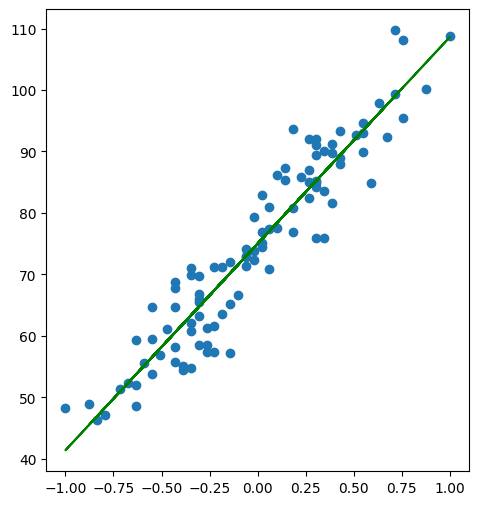

In [12]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=1000, verbose=100)

print(nn.layers[0].weights)
print(nn.layers[0].biases)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c="green")

### Regressão Linear Multivariada

In [13]:
data = np.loadtxt("data/notas.csv", delimiter=",", skiprows=1)
print(data.shape)

x, y = data[:, :-1], data[:, -1].reshape(-1, 1)
print(x.shape, y.shape)

(25, 4)
(25, 3) (25, 1)


In [14]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1. -1. -1.] [1. 1. 1.]


In [15]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=linear))
nn.fit(x, y, epochs=2000, verbose=200)

print(nn.layers[0].weights)
print(nn.layers[0].biases)

epoch:    0/2000 loss_train: 10119.62541731
epoch:  200/2000 loss_train: 6.61871673
epoch:  400/2000 loss_train: 3.92844919
epoch:  600/2000 loss_train: 3.20213559
epoch:  800/2000 loss_train: 2.98569782
epoch: 1000/2000 loss_train: 2.91365542
epoch: 1200/2000 loss_train: 2.88714116
epoch: 1400/2000 loss_train: 2.87662068
epoch: 1600/2000 loss_train: 2.87223897
epoch: 1800/2000 loss_train: 2.87036171
epoch: 2000/2000 loss_train: 2.86954486
[[ 8.92253939 13.98649079 26.17991583]]
[[150.6390144]]


### Regressão Quadrática

In [16]:
x, y = make_square(n_samples=100, x_min=-10, x_max=10, a=1, b=1, c=1, noise=10)

print(x.shape, y.shape)

(100, 1) (100, 1)


In [17]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/3000 loss_train: 1025.43482309
epoch:  300/3000 loss_train: 102.66446486
epoch:  600/3000 loss_train: 58.38617245
epoch:  900/3000 loss_train: 44.78502666
epoch: 1200/3000 loss_train: 56.30487667
epoch: 1500/3000 loss_train: 30.70051834
epoch: 1800/3000 loss_train: 45.70677102
epoch: 2100/3000 loss_train: 30.95705172
epoch: 2400/3000 loss_train: 117.97639245
epoch: 2700/3000 loss_train: 28.37093432
epoch: 3000/3000 loss_train: 27.40973975


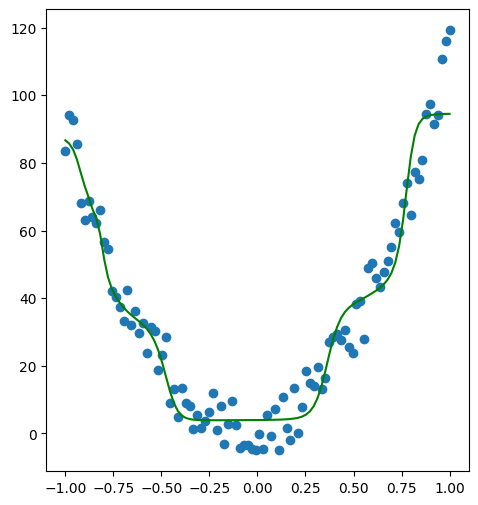

In [18]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-2)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=3000, verbose=300)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c="green")

### Regressão Cúbica

In [19]:
x, y = make_cubic(n_samples=100, x_min=-4, x_max=4, a=1, b=0, c=-10, d=0, noise=3)

print(x.shape, y.shape)

(100, 1) (100, 1)


In [20]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/1000 loss_train: 49.74854781
epoch:  100/1000 loss_train: 12.11638036
epoch:  200/1000 loss_train: 5.49878940
epoch:  300/1000 loss_train: 4.08727467
epoch:  400/1000 loss_train: 3.64374705
epoch:  500/1000 loss_train: 3.33668841
epoch:  600/1000 loss_train: 2.93420403
epoch:  700/1000 loss_train: 2.71125041
epoch:  800/1000 loss_train: 2.59823209
epoch:  900/1000 loss_train: 2.66594989
epoch: 1000/1000 loss_train: 2.59065625


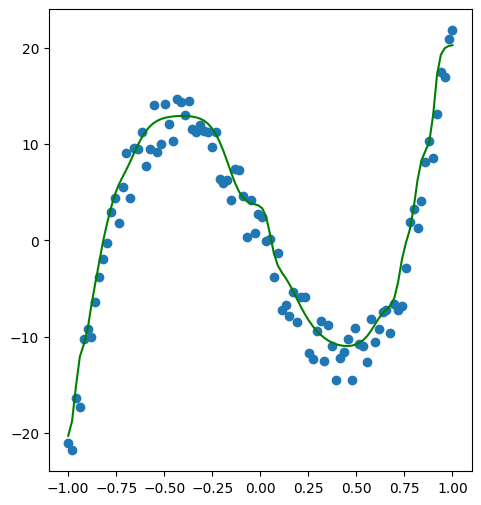

In [21]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=1000, verbose=100)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c="green")

### Regressão Logarítimica

In [22]:
x, y = make_log10(n_samples=100, x_min=1, x_max=100, noise=0.3)

print(x.shape, y.shape)

(100, 1) (100, 1)


In [23]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/1000 loss_train: 1.62538644
epoch:  100/1000 loss_train: 0.04778356
epoch:  200/1000 loss_train: 0.03357900
epoch:  300/1000 loss_train: 0.02897197
epoch:  400/1000 loss_train: 0.02799381
epoch:  500/1000 loss_train: 0.05300612
epoch:  600/1000 loss_train: 0.03104926
epoch:  700/1000 loss_train: 0.03104403
epoch:  800/1000 loss_train: 0.03001986
epoch:  900/1000 loss_train: 0.02909123
epoch: 1000/1000 loss_train: 0.02837851


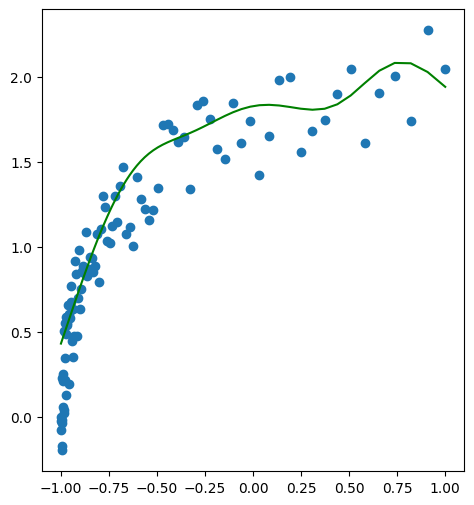

In [24]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=1000, verbose=100)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c="green")

### Regressão Exponencial

In [25]:
x, y = make_exp(n_samples=100, x_min=0, x_max=5, noise=10)

print(x.shape, y.shape)

(100, 1) (100, 1)


In [26]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/1000 loss_train: 1350.26602540
epoch:  100/1000 loss_train: 1116.34391739
epoch:  200/1000 loss_train: 1048.54970195
epoch:  300/1000 loss_train: 988.24982682
epoch:  400/1000 loss_train: 933.30114860
epoch:  500/1000 loss_train: 883.53898226
epoch:  600/1000 loss_train: 838.25048952
epoch:  700/1000 loss_train: 797.06262664
epoch:  800/1000 loss_train: 759.30961673
epoch:  900/1000 loss_train: 724.65676306
epoch: 1000/1000 loss_train: 692.75670732


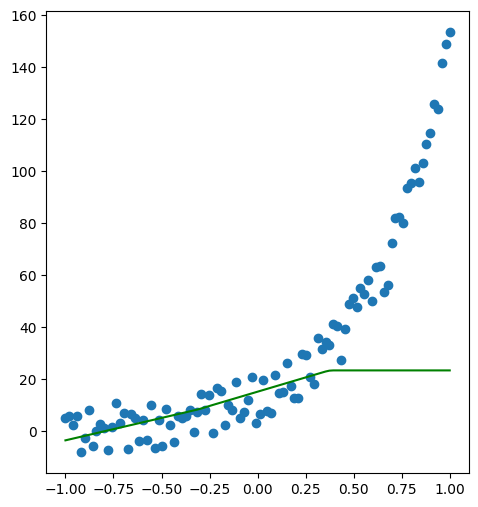

In [27]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=1000, verbose=100)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c="green")

## Classificação Binária

### Porta AND/OR

In [28]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 0, 0, 1]).reshape(-1, 1)  # porta AND

print(x.shape, y.shape)

(4, 2) (4, 1)


epoch:    0/1000 loss_train: 0.40698236
epoch:  100/1000 loss_train: 0.12150428
epoch:  200/1000 loss_train: 0.07372444
epoch:  300/1000 loss_train: 0.05252866
epoch:  400/1000 loss_train: 0.04065195
epoch:  500/1000 loss_train: 0.03309131
epoch:  600/1000 loss_train: 0.02787009
epoch:  700/1000 loss_train: 0.02405450
epoch:  800/1000 loss_train: 0.02114755
epoch:  900/1000 loss_train: 0.01886098
epoch: 1000/1000 loss_train: 0.01701639
[[7.46111743 7.46111895]] [[-11.36418033]]
Predições:
[[1.16036374e-05]
 [1.97808594e-02]
 [1.97808299e-02]
 [9.72295261e-01]]
Acurácia: 100.00%


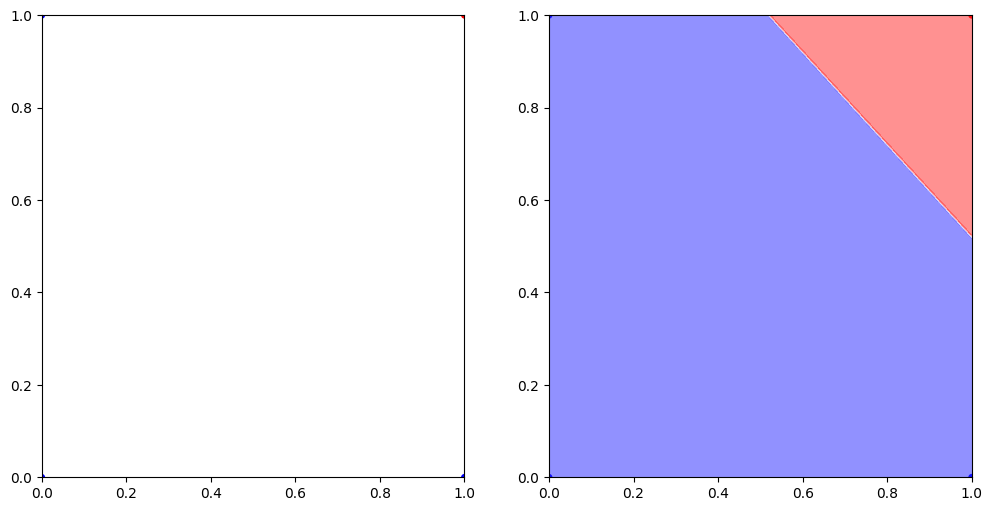

In [29]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1.0)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=1000, verbose=100)

print(nn.layers[0].weights, nn.layers[0].biases)

y_pred = nn.predict(x)
print("Predições:", y_pred, sep="\n")
print("Acurácia: {:.2f}%".format(100 * accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap="bwr")

### Porta XOR

In [30]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0]).reshape(-1, 1)

print(x.shape, y.shape)

(4, 2) (4, 1)


epoch:    0/1000 loss_train: 0.86829231
epoch:  100/1000 loss_train: 0.68249814
epoch:  200/1000 loss_train: 0.59619715
epoch:  300/1000 loss_train: 0.52779954
epoch:  400/1000 loss_train: 0.50471006
epoch:  500/1000 loss_train: 0.49407954
epoch:  600/1000 loss_train: 0.48556256
epoch:  700/1000 loss_train: 0.45238164
epoch:  800/1000 loss_train: 0.33742503
epoch:  900/1000 loss_train: 0.10639295
epoch: 1000/1000 loss_train: 0.05353283
Predições:
[[0.02770491]
 [0.94355388]
 [0.94385499]
 [0.06774683]]
Acurácia: 100.00%


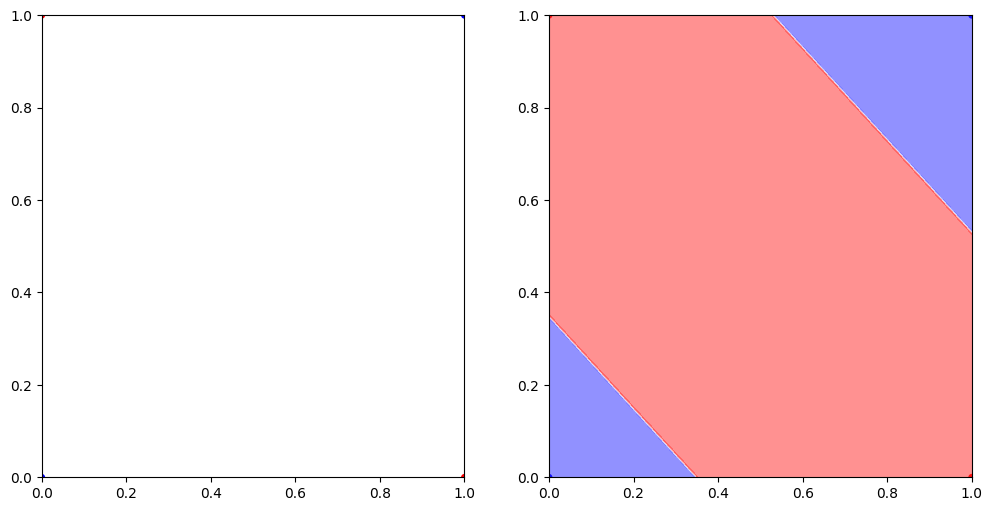

In [31]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1.0)
nn.layers.append(Layer(input_dim=D_in, output_dim=2, activation=sigmoid))
nn.layers.append(Layer(input_dim=2, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=1000, verbose=100)

y_pred = nn.predict(x)
print("Predições:", y_pred, sep="\n")
print("Acurácia: {:.2f}%".format(100 * accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap="bwr")

### 2 Clusters

In [32]:
x, y = make_blobs(n_samples=100, n_features=2, centers=2, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(100, 2) (100, 1)


epoch:    0/5000 loss_train: 2.92475655
epoch: 1000/5000 loss_train: 0.00688603
epoch: 2000/5000 loss_train: 0.00467217
epoch: 3000/5000 loss_train: 0.00371950
epoch: 4000/5000 loss_train: 0.00315343
epoch: 5000/5000 loss_train: 0.00276610
Acurácia: 100.00%


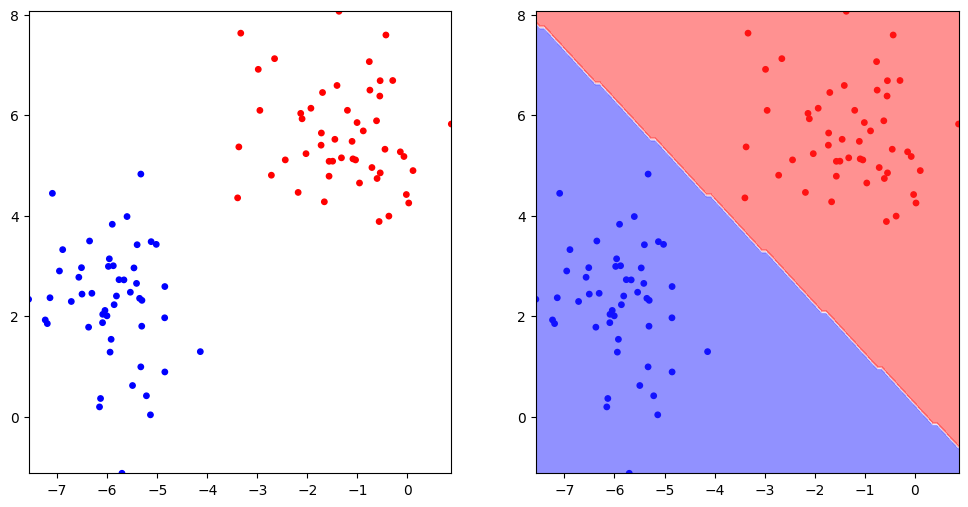

In [33]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=5000, verbose=1000)

y_pred = nn.predict(x)

print("Acurácia: {:.2f}%".format(100 * accuracy_score(y, y_pred >= 0.5)))
plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap="bwr")

### 4 Clusters

In [34]:
x, y = make_blobs(
    n_samples=500, n_features=2, cluster_std=0.9, centers=[(-3, -3), (3, 3), (-3, 3), (3, -3)], random_state=1234
)
y = y.reshape(-1, 1)
y = np.where(y >= 2, 1, 0)

print(x.shape, y.shape)

(500, 2) (500, 1)


epoch:    0/500 loss_train: 3.64990135
epoch:  100/500 loss_train: 0.01241721
epoch:  200/500 loss_train: 0.00681770
epoch:  300/500 loss_train: 0.00483713
epoch:  400/500 loss_train: 0.00379423
epoch:  500/500 loss_train: 0.00314098
Acurácia: 100.00%


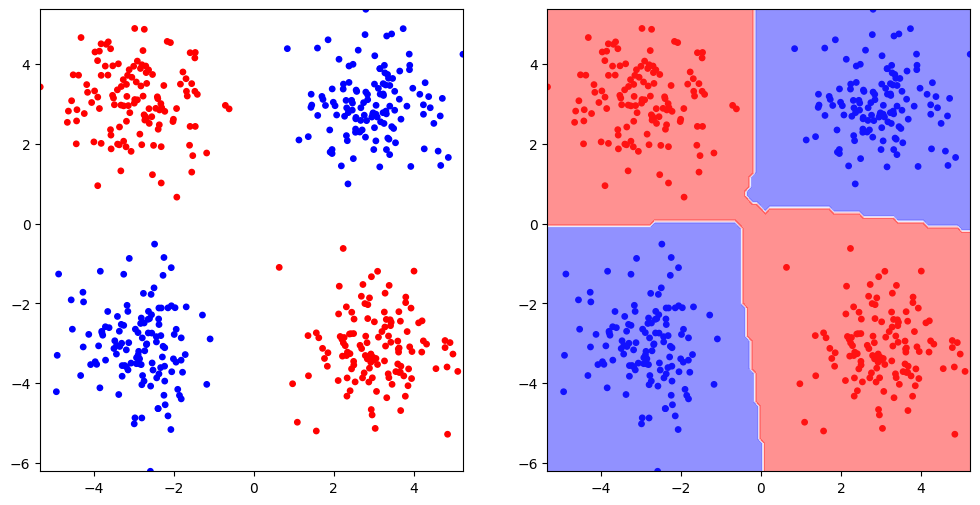

In [35]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=500, verbose=100)

y_pred = nn.predict(x)
print("Acurácia: {:.2f}%".format(100 * accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap="bwr")

### Círculos

In [36]:
x, y = make_circles(n_samples=500, noise=0.1, factor=0.4, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(500, 2) (500, 1)


epoch:    0/1000 loss_train: 1.18011452
epoch:  100/1000 loss_train: 0.18361132
epoch:  200/1000 loss_train: 0.06676732
epoch:  300/1000 loss_train: 0.03665072
epoch:  400/1000 loss_train: 0.02471155
epoch:  500/1000 loss_train: 0.01849080
epoch:  600/1000 loss_train: 0.01468076
epoch:  700/1000 loss_train: 0.01215350
epoch:  800/1000 loss_train: 0.01037018
epoch:  900/1000 loss_train: 0.00904047
epoch: 1000/1000 loss_train: 0.00800905
Acurácia: 100.00%


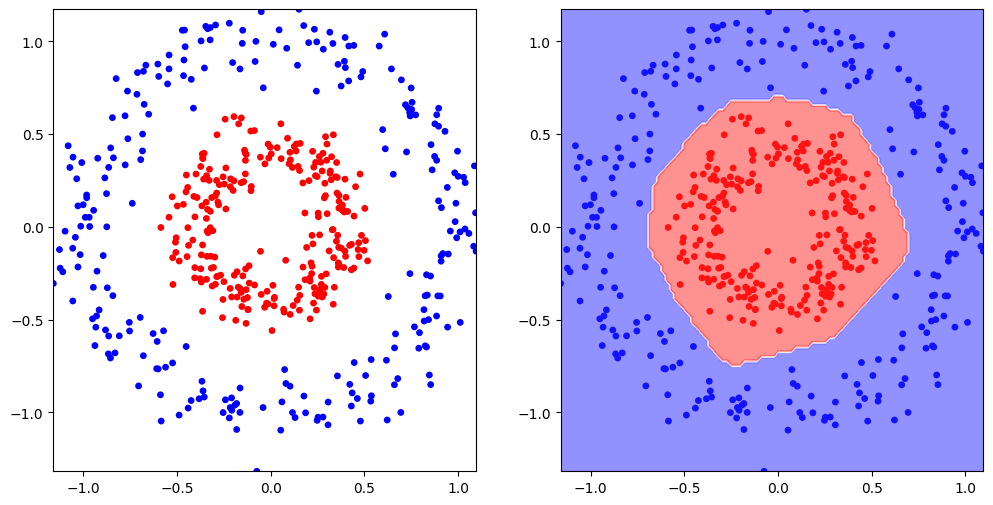

In [37]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=D_in, output_dim=8, activation=relu))
nn.layers.append(Layer(input_dim=8, output_dim=8, activation=relu))
nn.layers.append(Layer(input_dim=8, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=1000, verbose=100)

y_pred = nn.predict(x)
print("Acurácia: {:.2f}%".format(100 * accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap="bwr")

### Moons

In [38]:
x, y = make_moons(200, noise=0.20)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(200, 2) (200, 1)


epoch:    0/2000 loss_train: 1.43413751
epoch:  200/2000 loss_train: 0.29151356
epoch:  400/2000 loss_train: 0.26444785
epoch:  600/2000 loss_train: 0.23927952
epoch:  800/2000 loss_train: 0.21293801
epoch: 1000/2000 loss_train: 0.18848779
epoch: 1200/2000 loss_train: 0.16695608
epoch: 1400/2000 loss_train: 0.14769111
epoch: 1600/2000 loss_train: 0.13080465
epoch: 1800/2000 loss_train: 0.11680216
epoch: 2000/2000 loss_train: 0.10557497
Acurácia: 96.50%


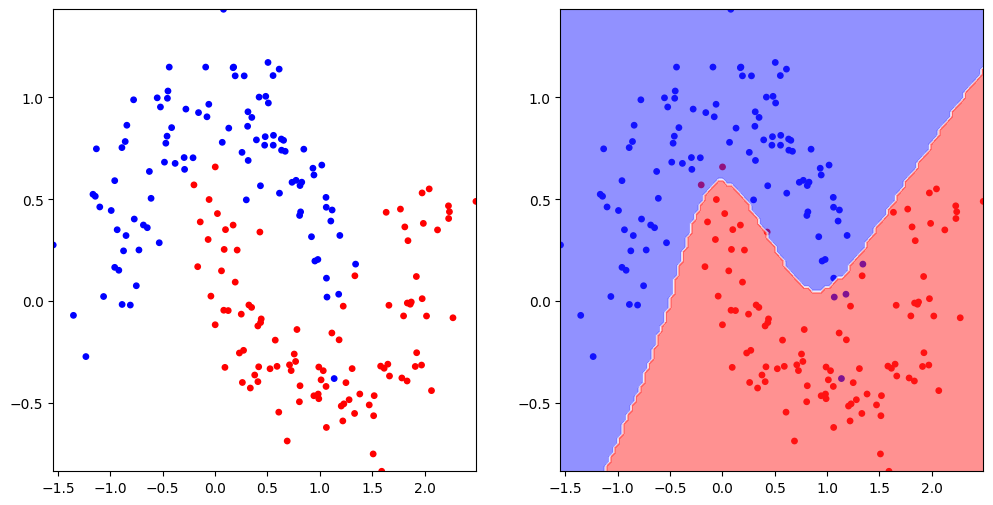

In [39]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=2000, verbose=200)

y_pred = nn.predict(x)
print("Acurácia: {:.2f}%".format(100 * accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap="bwr")

### Espiral

In [40]:
x, y = make_spiral(n_samples=100, n_class=2, radius=5, laps=1.75)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(200, 2) (200, 1)


epoch:    0/5000 loss_train: 1.02790095
epoch:  500/5000 loss_train: 0.22332197
epoch: 1000/5000 loss_train: 0.10353024
epoch: 1500/5000 loss_train: 0.05669922
epoch: 2000/5000 loss_train: 0.03873218
epoch: 2500/5000 loss_train: 0.02972499
epoch: 3000/5000 loss_train: 0.02442894
epoch: 3500/5000 loss_train: 0.02097820
epoch: 4000/5000 loss_train: 0.01857749
epoch: 4500/5000 loss_train: 0.01682822
epoch: 5000/5000 loss_train: 0.01550344
Acurácia: 99.50%


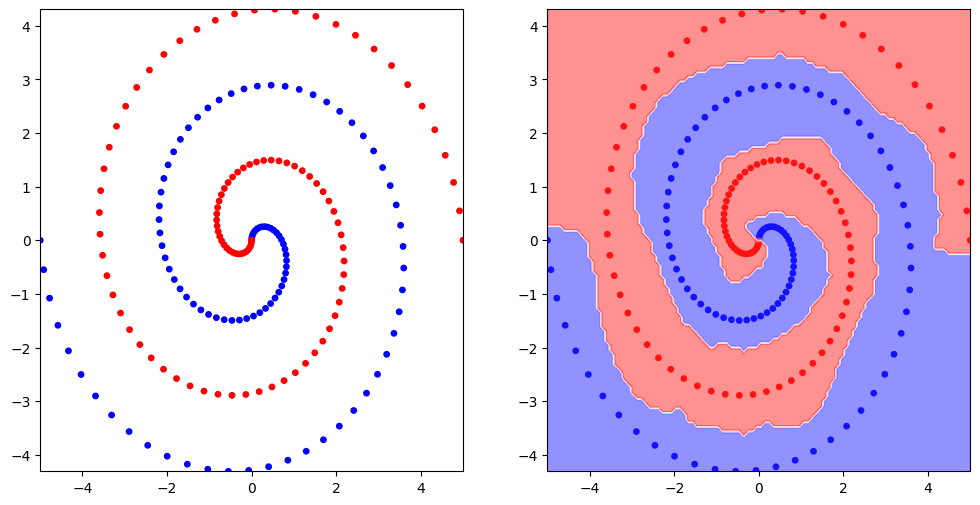

In [41]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=D_in, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim=20, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim=20, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=5000, verbose=500)

y_pred = nn.predict(x)
print("Acurácia: {:.2f}%".format(100 * accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap="bwr")

## Classificação Multiclasse

### 3 Clusters

In [42]:
x, y = make_blobs(n_samples=300, n_features=2, centers=[(0, -3), (-3, 3), (3, 3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(300, 2) (300, 1)


In [43]:
onehot = OneHotEncoder(sparse_output=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::60])

[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


epoch:    0/1000 loss_train: 1.66499865
epoch:  100/1000 loss_train: 0.01114382
epoch:  200/1000 loss_train: 0.00598380
epoch:  300/1000 loss_train: 0.00410232
epoch:  400/1000 loss_train: 0.00312410
epoch:  500/1000 loss_train: 0.00252483
epoch:  600/1000 loss_train: 0.00212253
epoch:  700/1000 loss_train: 0.00183093
epoch:  800/1000 loss_train: 0.00160981
epoch:  900/1000 loss_train: 0.00143641
epoch: 1000/1000 loss_train: 0.00129660
[[ 8.80177278e-01 -6.95110236e-01]
 [-1.11528125e-03 -2.97003507e-01]
 [-1.55173862e+00  1.00902825e+00]
 [-9.58308488e-03 -1.49915002e+00]
 [ 3.50209474e-01 -7.02565163e-01]
 [-2.23993169e-02 -1.05054187e+00]
 [ 2.80194598e-02 -6.07793087e-02]
 [ 5.02014236e-01 -7.26958737e-01]
 [ 7.88039225e-01  9.80501825e-01]
 [ 1.07924916e+00  6.03234095e-01]]
[[ 0.46891905  0.56608477 -0.42574005  0.87409271  0.60772609 -0.08943194
  -0.24470785 -0.75542471 -2.6919874   1.90595208]
 [-0.07589786  1.53283934  1.46232757 -0.33928595 -0.10437169 -0.44527404
   1.52437

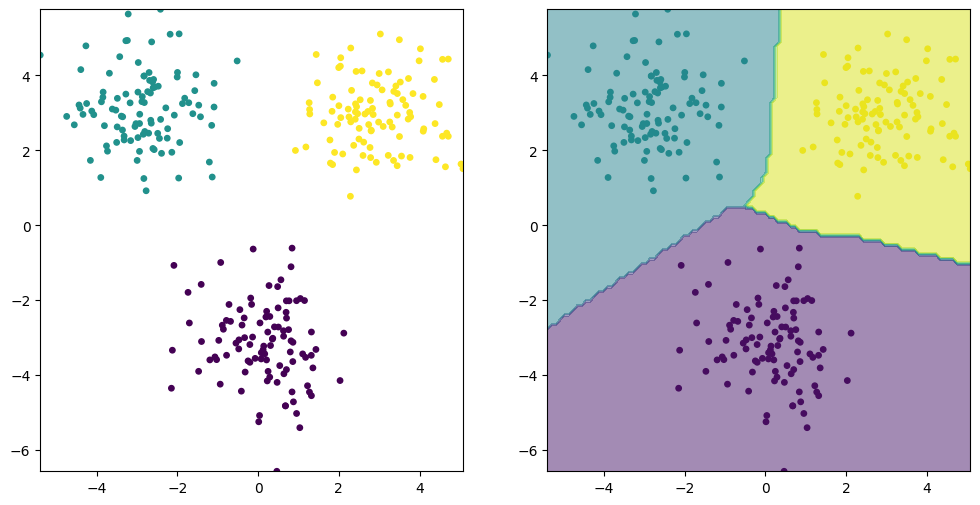

In [44]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=1000, verbose=100)

for layer in nn.layers:
    print(layer.weights)

y_pred = np.argmax(nn.predict(x), axis=1)
print("Acurácia: {:.2f}%".format(100 * accuracy_score(y, y_pred)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

### 4 Clusters

In [45]:
x, y = make_blobs(n_samples=400, n_features=2, centers=[(-3, 0), (3, 0), (0, 3), (0, -3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(400, 2) (400, 1)


In [46]:
onehot = OneHotEncoder(sparse_output=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::70])

[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]


epoch:    0/1000 loss_train: 3.28353148
epoch:  100/1000 loss_train: 0.10251942
epoch:  200/1000 loss_train: 0.08908406
epoch:  300/1000 loss_train: 0.08401913
epoch:  400/1000 loss_train: 0.08072643
epoch:  500/1000 loss_train: 0.07793575
epoch:  600/1000 loss_train: 0.07642776
epoch:  700/1000 loss_train: 0.07527695
epoch:  800/1000 loss_train: 0.07438210
epoch:  900/1000 loss_train: 0.07365478
epoch: 1000/1000 loss_train: 0.07304561
Acurácia: 97.50%


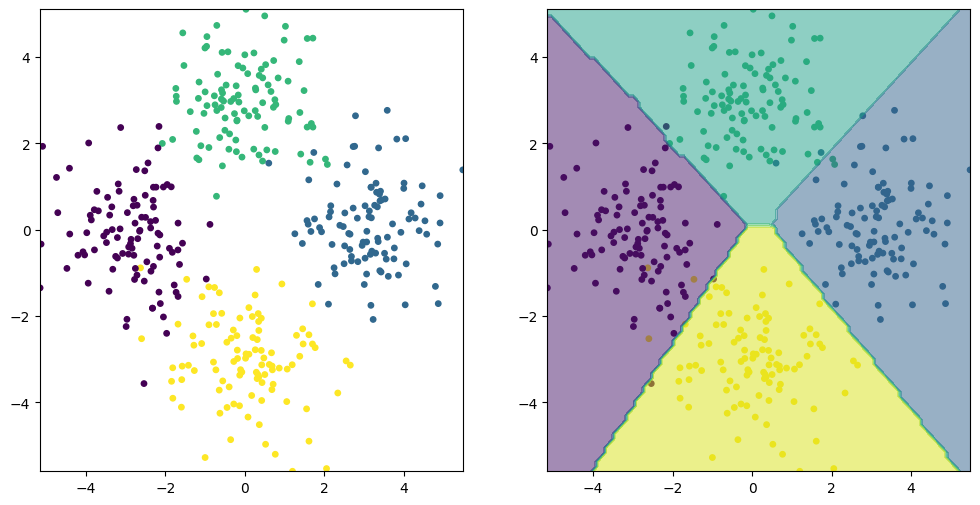

In [47]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=D_in, output_dim=5, activation=relu))
nn.layers.append(Layer(input_dim=5, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=1000, verbose=100)

y_pred = np.argmax(nn.predict(x), axis=1)
print("Acurácia: {:.2f}%".format(100 * accuracy_score(y, y_pred)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

### Espiral - 5 classes

In [48]:
x, y = make_spiral(n_samples=100, n_class=5, radius=1, laps=0.5)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(500, 2) (500, 1)


In [49]:
onehot = OneHotEncoder(sparse_output=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::100])

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


epoch:    0/2000 loss_train: 4.13327431
epoch:  200/2000 loss_train: 0.88417169
epoch:  400/2000 loss_train: 0.62213727
epoch:  600/2000 loss_train: 0.46116754
epoch:  800/2000 loss_train: 0.35543275
epoch: 1000/2000 loss_train: 0.28281423
epoch: 1200/2000 loss_train: 0.23110512
epoch: 1400/2000 loss_train: 0.19274642
epoch: 1600/2000 loss_train: 0.16303765
epoch: 1800/2000 loss_train: 0.13584712
epoch: 2000/2000 loss_train: 0.11752130
Acurácia: 98.00%


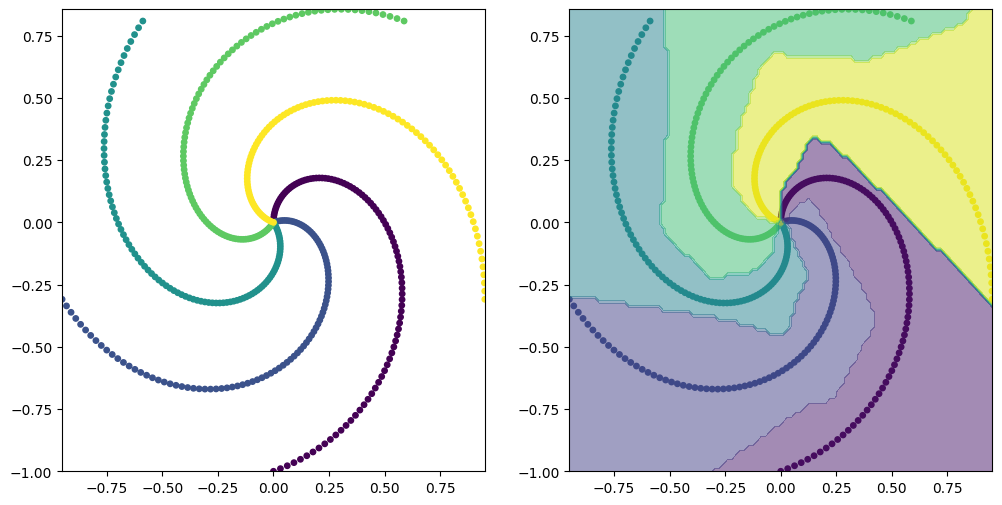

In [50]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=2000, verbose=200)

y_pred = np.argmax(nn.predict(x), axis=1)
print("Acurácia: {:.2f}%".format(100 * accuracy_score(y, y_pred)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

### Make Classification - 4 Classes

In [51]:
x, y = make_classification(
    n_samples=100, n_classes=4, n_features=2, n_clusters_per_class=1, n_redundant=0, n_repeated=0, random_state=1234
)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(100, 2) (100, 1)


In [52]:
onehot = OneHotEncoder(sparse_output=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::10])

[[0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]


epoch:    0/1000 loss_train: 2.46595184
epoch:  100/1000 loss_train: 0.48952430
epoch:  200/1000 loss_train: 0.39478627
epoch:  300/1000 loss_train: 0.33506520
epoch:  400/1000 loss_train: 0.30636895
epoch:  500/1000 loss_train: 0.28562546
epoch:  600/1000 loss_train: 0.25625846
epoch:  700/1000 loss_train: 0.23650123
epoch:  800/1000 loss_train: 0.22303868
epoch:  900/1000 loss_train: 0.21388812
epoch: 1000/1000 loss_train: 0.20653430
Acurácia: 95.00%


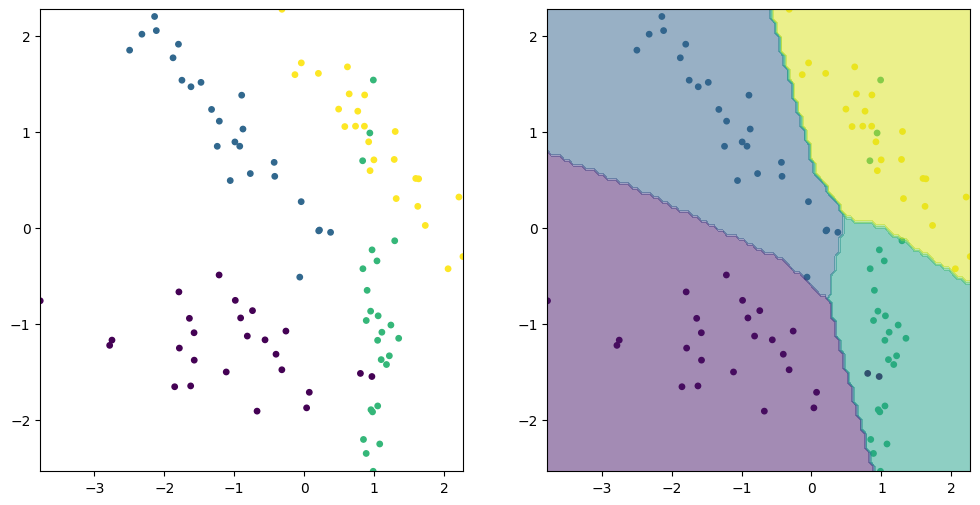

In [53]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=D_in, output_dim=5, activation=relu))
nn.layers.append(Layer(input_dim=5, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=1000, verbose=100)

y_pred = np.argmax(nn.predict(x), axis=1)
print("Acurácia: {:.2f}%".format(100 * accuracy_score(y, y_pred)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

### Iris Dataset

In [54]:
data = load_iris()
x, y = data.data[:, 2:], data.target.reshape(-1, 1)

print(data.feature_names)
print(data.target_names)
print(x.shape, y.shape)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']
(150, 2) (150, 1)


In [55]:
onehot = OneHotEncoder(sparse_output=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::20])

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


epoch:    0/2000 loss_train: 1.60243925
epoch:  200/2000 loss_train: 1.09861430
epoch:  400/2000 loss_train: 1.09861229
epoch:  600/2000 loss_train: 1.09861229
epoch:  800/2000 loss_train: 1.09861229
epoch: 1000/2000 loss_train: 1.09861229
epoch: 1200/2000 loss_train: 1.09861229
epoch: 1400/2000 loss_train: 1.09861229
epoch: 1600/2000 loss_train: 1.09861229
epoch: 1800/2000 loss_train: 1.09861229
epoch: 2000/2000 loss_train: 1.09861229
Acurácia: 33.33%


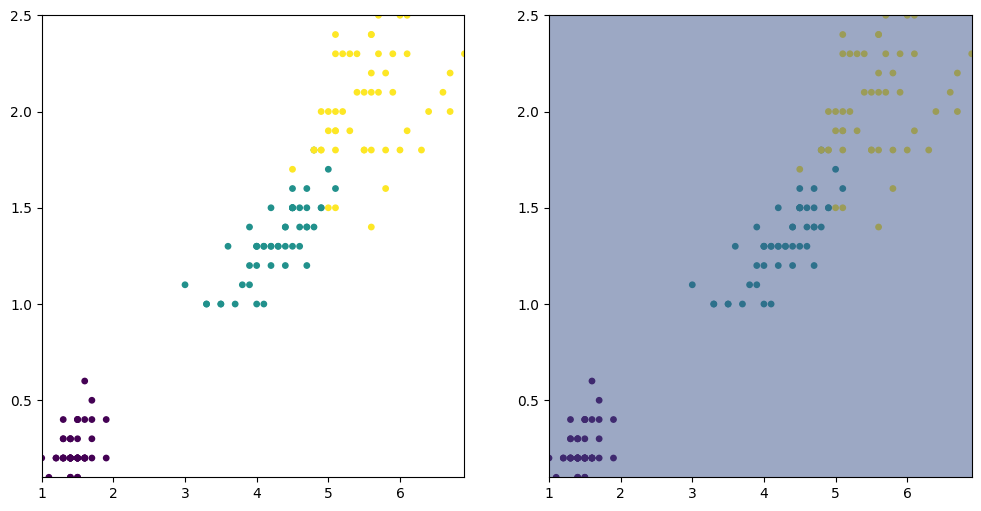

In [56]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=D_in, output_dim=2, activation=relu))
nn.layers.append(Layer(input_dim=2, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=2000, verbose=200)

y_pred = np.argmax(nn.predict(x), axis=1)
print("Acurácia: {:.2f}%".format(100 * accuracy_score(y, y_pred)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

# 5. Referências 

- [Implementação completa de Redes Neurais com momentum, regularização, dropout, batch normalization, etc...](https://github.com/arnaldog12/Manual-Pratico-Deep-Learning/blob/master/Rede%20Neural.ipynb)